In [2]:
#Import packages
#---------------------------------------
import sys
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
import warnings
import random
import arviz as az
import pymc as pm
warnings.filterwarnings("ignore", category=RuntimeWarning) 

#Import your modules
#---------------------------------------
import admin_functions as adfn
import cell_decomp_func as cdfn


# Define paths
#----------------------------------------------------------------------
l_code = '/Users/dominicburrows/Dropbox/PhD/Analysis/my_scripts/GitHub/'
l_data = '/Users/dominicburrows/Dropbox/PhD/analysis/Project/'
l_fig = '/Users/dominicburrows/Dropbox/PhD/figures/'

s_code = '/cndd3/dburrows/CODE/'
s_data = '/cndd3/dburrows/DATA/'
%load_ext autoreload
sys.version

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'3.11.0 | packaged by conda-forge | (main, Jan 14 2023, 12:27:40) [GCC 11.3.0]'

In [ ]:

#====================================
def eigendecomposition(data):
#====================================
    """
        This function gets the eigenvalues and eigenvectors of a data matrix, where columns = features and rows = samples 
        -> dim reduction is done over the features.
        
   
    Inputs:
        data (np array): n x d array of n samples and d features. 

    Outputs:
        eigenvalues (np array): 1d vector of sorted eigenvalues
        eigenvectors (np array): n x p array of n samples and k principal components

    """

    import numpy as np


    #Rows = samples, Columns = features, we will do dim red over the features
    zc = (data - np.mean(data,axis=0)) #zero centre across columns 
    scaled = zc/np.std(zc,axis=0) # make SD = 1 across columns
    cov = np.dot(scaled.T, scaled) #covariance matrix
    eigenvalues, eigenvectors = np.linalg.eig(cov) 
    D = np.diag(eigenvalues)
    P = eigenvectors

    return(np.real(eigenvalues), eigenvectors)


#====================================
def pca(data, k):
#====================================
    """
        This function finds a change of basis using n PCs and projects data into this new basis.
   
    Inputs:
        data (np array): n x d array of n samples and d features. 
        k (int): number of principal components

    Outputs:
        Z (np array): n x p array of original data projected onto top k PCs, with n samples and k principal components
   
    """
    import numpy as np

    #Rows = samples, Columns = features, we will do dim red over the features
    zc = (data - np.mean(data,axis=0)) #zero centre across columns 
    scaled = zc/np.std(zc,axis=0) # make SD = 1 across columns
    cov = np.dot(scaled.T, scaled) #covariance matrix
    eigenvalues, eigenvectors = np.linalg.eig(cov) 
    D = np.diag(eigenvalues)
    P = eigenvectors
    Z = np.dot(data, P[:,:k]) #projected data with top n components 

    return(Z)

In [3]:
from sklearn.decomposition import PCA
def prac_pca(data, k):
    zero_data = (data - np.mean(data,axis=0)) #zero centre across columns 
    cov=np.cov(zero_data, rowvar=False) #covariance matrix
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    idx = np.argsort(eigenvalues)[::-1]
    eigenvectors = eigenvectors[:,idx]
    eigenvalues = eigenvalues[idx]
    P = eigenvectors[:,:k]
    Z = np.dot(zero_data, P[:,:k]) #projected data with top n components
    return(Z,P)

In [5]:
# START
import time

#Set default parameters
n_clusts = 20
n_genes = 500
n_cells = 100
rate_range = 0,40 #max and min of uniform distribution for generating rates
noise_type = 'exponential' #CHANGE!

start_time = time.time()
#Simulate spot data from simulated gene expression
spot_sim = cdfn.simulate_cell_mix(n_clusts, n_cells, n_genes).simulate_gene_exp(rate_range, 0)


Loaded parameters: 20 cell types , 100 cells, & 500 genes.
Created spot mixtures from simulated data: 36 spots.


In [13]:
k=10
#MINE
n_spots = spot_sim.__dict__['n_spots']
spots = spot_sim.__dict__['spots']
prop_vec = spot_sim.__dict__['prop_vec']
ref_exp = spot_sim.__dict__['mean_exps']

clf=PCA(k)
zero_data = (ref_exp - np.mean(ref_exp,axis=0))
X_train=zero_data
p_=clf.fit_transform(X_train)
comp = clf.components_


In [9]:
X_train.shape

(20, 500)

In [27]:
comp.shape, p_.shape

((10, 500), (20, 10))

In [10]:
p_.shape

(20, 20)

In [25]:
np.dot(X_train, comp.T)[0,:100]

array([-8.53539439e-03,  7.80945082e-03,  9.34871969e-04, -2.57604411e-03,
        5.24788634e-05,  9.97895882e-05, -1.77595544e-03,  1.14398847e-02,
       -6.13727386e-03,  1.19090401e-02])

In [26]:
p_[0,:100]

array([-8.53539439e-03,  7.80945082e-03,  9.34871969e-04, -2.57604411e-03,
        5.24788634e-05,  9.97895882e-05, -1.77595544e-03,  1.14398847e-02,
       -6.13727386e-03,  1.19090401e-02])

In [84]:
spots.shape, comp.shape

((35, 500), (5, 500))

In [85]:
spots = np.dot(spots, comp.T)
spots.shape

(35, 5)

(<matplotlib.image.AxesImage at 0x7feb58a5f3d0>,
 <matplotlib.image.AxesImage at 0x7feb508ea150>)

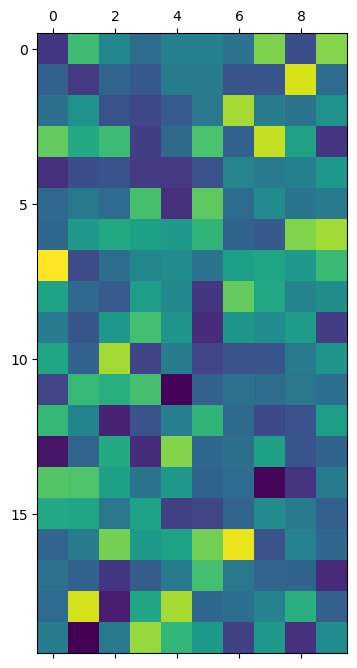

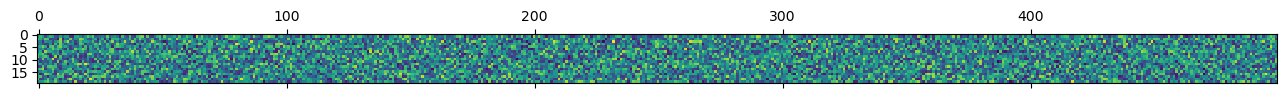

In [14]:
plt.matshow(p_), plt.matshow(X_train)

In [45]:
p_.shape, comp.shape

((20, 20), (20, 500))

cell expression (20, 500) cells x genes


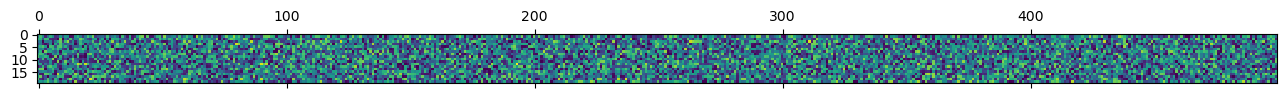

In [15]:
print('cell expression', ref_exp.shape, 'cells x genes')
plt.matshow(ref_exp)

Principal Components (10, 500) PCs x genes


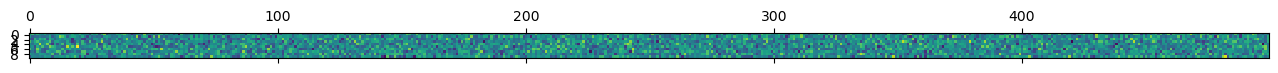

In [16]:
print('Principal Components', comp.shape, 'PCs x genes')
plt.matshow(comp)

Cell expression projected onto PCs (20, 10) Cells x PCs


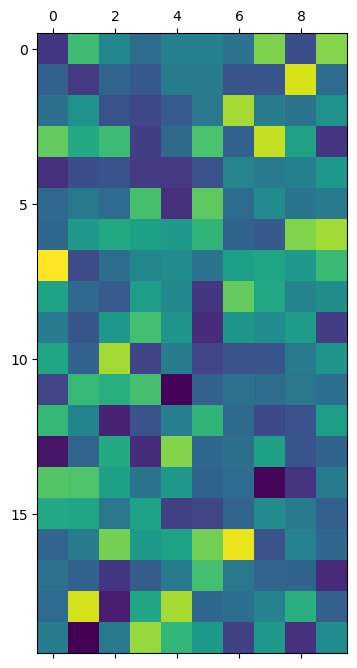

In [17]:
print('Cell expression projected onto PCs', p_.shape, 'Cells x PCs')
plt.matshow(p_)

In [93]:
k_list = np.arange(1,10)
k_list

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [95]:
r_list

[0.00015360918277675106,
 0.0001820690881820504,
 0.019201910048560544,
 0.06072122858757689,
 0.33891336059063026,
 0.1497172773126767,
 0.4057346219392616,
 0.22977926247821415,
 0.2927051414475914,
 9]

In [94]:
# Run alpha noise
import time
r_list = list(range(10))
for r,k in enumerate(k_list):
    #Set default parameters
    n_clusts = 10
    n_genes = 500
    n_cells = 100
    rate_range = 0,40 #max and min of uniform distribution for generating rates
    noise_type = 'exponential' #CHANGE!

    start_time = time.time()
    #Simulate spot data from simulated gene expression
    spot_sim = cdfn.simulate_cell_mix(n_clusts, n_cells, n_genes).simulate_gene_exp(rate_range, 0)
    n_spots = spot_sim.__dict__['n_spots']
    spots = spot_sim.__dict__['spots']
    ref_exp = spot_sim.__dict__['mean_exps']
    prop_vec = spot_sim.__dict__['prop_vec']

    clf=PCA(k)
    zero_data = (ref_exp - np.mean(ref_exp,axis=0))
    X_train=zero_data
    ref_exp=clf.fit_transform(X_train)
    comp = clf.components_
    spots = np.dot(spots, comp.T)

    n_genes=k
    #Simple Linear regression
    with pm.Model(coords={"celltypes": np.arange(n_clusts),
                        "spots": np.arange(n_spots),
                        "genes": np.arange(n_genes) }) as model:
        #Declare data 
        mean_exp = pm.Data('mean_exp', ref_exp, mutable=False, dims=['celltypes','genes'])
        # Priors for unknown model parameters
        beta=pm.HalfNormal("beta", sigma=1, dims=['spots','celltypes'])
        lmd= pm.Deterministic('lmd', pm.math.dot(beta, mean_exp), dims=['spots','genes'])
        #Convert from proportions to counts
        N_g = pm.Data('N_g', np.sum(spots, 1).reshape(n_spots,1), mutable=False)
        #Likelihood of observed data given Poisson rates
        y=pm.Normal("y", mu=lmd*N_g, sigma=1, observed=spots)
    with model: data=pm.sample(random_seed=1,draws=200,chains=1, discard_tuned_samples=False)
    post, r2 = cdfn.model_stats(data, prop_vec, n_clusts)
    r_list[r] = r2


Sampling 1 chain for 1_000 tune and 200 draw iterations (1_000 + 200 draws total) took 32 seconds.
/home/dburrows/anaconda3/envs/pymc_conda/lib/python3.11/site-packages/arviz/data/base.py:221: UserWarning: More chains (200) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
/home/dburrows/anaconda3/envs/pymc_conda/lib/python3.11/site-packages/arviz/data/base.py:221: UserWarning: More chains (1000) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


In [92]:
r_list

[0.2573876336425387,
 0.056100214994811555,
 0.21782396678198473,
 0.17584898803750187,
 0.2703536084328579,
 0.3840050099878839,
 0.20934723944379885,
 0.353398719644409,
 0.34978580640566115,
 0.2047623633486103]

In [34]:
spot_sim = cdfn.simulate_cell_mix(n_clusts, n_cells, n_genes).simulate_gene_exp(rate_range, 0)

k=10
#MINE
n_spots = spot_sim.__dict__['n_spots']
spots = spot_sim.__dict__['spots']
prop_vec = spot_sim.__dict__['prop_vec']

ref_exp = spot_sim.__dict__['mean_exps']
ref_exp,P = prac_pca(ref_exp, k)
#k = 500#int(n_genes * p) #sum((eigval/np.sum(eigval)) > 0.005) 
#spots = cdfn.add_noise(spots, per=None, a_std=5, g_std=5, e_std=5, noise_type=noise_type) #CHANGE!
spots = np.dot(spots, P[:,:k])

n_genes=k
#Simple Linear regression
with pm.Model(coords={"celltypes": np.arange(n_clusts),
                    "spots": np.arange(n_spots),
                    "genes": np.arange(n_genes) }) as model:
    #Declare data 
    mean_exp = pm.Data('mean_exp', ref_exp, mutable=False, dims=['celltypes','genes'])
    # Priors for unknown model parameters
    beta=pm.HalfNormal("beta", sigma=1, dims=['spots','celltypes'])
    lmd= pm.Deterministic('lmd', pm.math.dot(beta, mean_exp), dims=['spots','genes'])
    #Convert from proportions to counts
    N_g = pm.Data('N_g', np.sum(spots, 1).reshape(n_spots,1), mutable=False)
    #Likelihood of observed data given Poisson rates
    y=pm.Normal("y", mu=lmd*N_g, sigma=1, observed=spots)
with model: data=pm.sample(random_seed=1,draws=500,chains=1, discard_tuned_samples=False)
post, r2 = cdfn.model_stats(data, prop_vec, n_clusts)

[0.006705949654931236,
 0.13925270037066947,
 0.8873332136342745,
 0.8234753901863596,
 0.7289825974547907,
 0.4549581838361886,
 0.0978693488043271,
 0.3633779317459666]

In [25]:
# START
import time

#Set default parameters
n_clusts = 5
n_genes = 500
n_cells = 100
rate_range = 0,40 #max and min of uniform distribution for generating rates
noise_type = 'exponential' #CHANGE!

start_time = time.time()
#Simulate spot data from simulated gene expression
spot_sim = cdfn.simulate_cell_mix(n_clusts, n_cells, n_genes).simulate_gene_exp(rate_range, 0)


Loaded parameters: 5 cell types , 100 cells, & 500 genes.
Created spot mixtures from simulated data: 33 spots.


In [26]:
def prac_pca(data, k):
    zero_data = (data - np.mean(data,axis=0)) #zero centre across columns 
    cov=np.cov(zero_data, rowvar=False) #covariance matrix
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    idx = np.argsort(eigenvalues)[::-1]
    eigenvectors = eigenvectors[:,idx]
    eigenvalues = eigenvalues[idx]
    P = eigenvectors[:,:k]
    Z = np.dot(zero_data, P[:,:k]) #projected data with top n components
    return(Z,P)

In [36]:
spot_sim = cdfn.simulate_cell_mix(n_clusts, n_cells, n_genes).simulate_gene_exp(rate_range, 0)

k=10
#MINE
n_spots = spot_sim.__dict__['n_spots']
spots = spot_sim.__dict__['spots']
prop_vec = spot_sim.__dict__['prop_vec']

ref_exp = spot_sim.__dict__['mean_exps']
ref_exp,P = prac_pca(ref_exp, k)
#k = 500#int(n_genes * p) #sum((eigval/np.sum(eigval)) > 0.005) 
#spots = cdfn.add_noise(spots, per=None, a_std=5, g_std=5, e_std=5, noise_type=noise_type) #CHANGE!
spots = np.dot(spots, P[:,:k])

n_genes=k
#Simple Linear regression
with pm.Model(coords={"celltypes": np.arange(n_clusts),
                    "spots": np.arange(n_spots),
                    "genes": np.arange(n_genes) }) as model:
    #Declare data 
    mean_exp = pm.Data('mean_exp', ref_exp, mutable=False, dims=['celltypes','genes'])
    # Priors for unknown model parameters
    beta=pm.HalfNormal("beta", sigma=1, dims=['spots','celltypes'])
    lmd= pm.Deterministic('lmd', pm.math.dot(beta, mean_exp), dims=['spots','genes'])
    #Convert from proportions to counts
    N_g = pm.Data('N_g', np.sum(spots, 1).reshape(n_spots,1), mutable=False)
    #Likelihood of observed data given Poisson rates
    y=pm.Normal("y", mu=lmd*N_g, sigma=1, observed=spots)
with model: data=pm.sample(random_seed=1,draws=500,chains=1, discard_tuned_samples=False)
post, r2 = cdfn.model_stats(data, prop_vec, n_clusts)

Sampling 1 chain for 1_000 tune and 500 draw iterations (1_000 + 500 draws total) took 84 seconds.
/home/dburrows/anaconda3/envs/pymc_conda/lib/python3.11/site-packages/arviz/data/base.py:221: UserWarning: More chains (500) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
/home/dburrows/anaconda3/envs/pymc_conda/lib/python3.11/site-packages/arviz/data/base.py:221: UserWarning: More chains (1000) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


In [37]:
r2

0.5141199425053

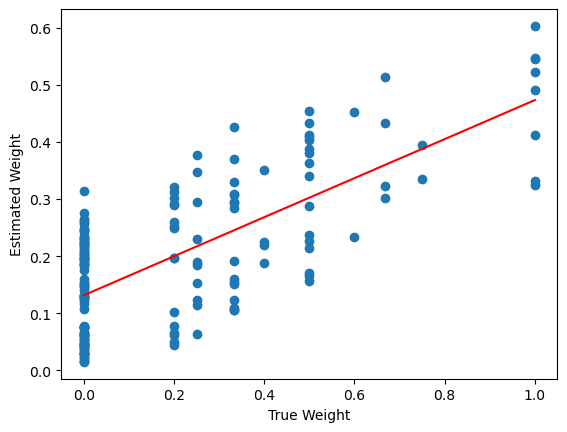

In [38]:
#Check performance
from scipy.stats import linregress

mean_post=post

plt.scatter(np.ravel(prop_vec), np.ravel(mean_post))
plt.xlabel("True Weight")
plt.ylabel("Estimated Weight")

line_fit=linregress(np.ravel(prop_vec), np.ravel(mean_post))

# Create sequence of 100 numbers from 0 to 100 
xseq = np.linspace(0, 1, num=100)

# Plot regression line
plt.plot(xseq, line_fit.intercept + line_fit.slope*xseq, 'r',)
plt.annotate("r-squared = {:.3f}".format(line_fit.rvalue**2), (0, 1))
plt.show()

In [16]:
spot_sim = cdfn.simulate_cell_mix(n_clusts, n_cells, n_genes).simulate_gene_exp(rate_range, 0)
n_spots = spot_sim.__dict__['n_spots']
spots = spot_sim.__dict__['spots']
ref_exp = spot_sim.__dict__['mean_exps']

eigval, eigvec = adfn.eigendecomposition(ref_exp)
k = 500#int(n_genes * p) #sum((eigval/np.sum(eigval)) > 0.005) 
ref_exp = np.real(adfn.pca(ref_exp, k))
prop_vec = spot_sim.__dict__['prop_vec']
spots = cdfn.add_noise(spots, per=None, a_std=5, g_std=5, e_std=5, noise_type=noise_type) #CHANGE!
spots = np.real(np.dot(spots, eigvec[:,:k]))

#Simple Linear regression
with pm.Model(coords={"celltypes": np.arange(n_clusts),
                    "spots": np.arange(n_spots),
                    "genes": np.arange(n_genes) }) as model:
    #Declare data 
    mean_exp = pm.Data('mean_exp', ref_exp, mutable=False, dims=['celltypes','genes'])
    # Priors for unknown model parameters
    beta=pm.HalfNormal("beta", sigma=1, dims=['spots','celltypes'])
    lmd= pm.Deterministic('lmd', pm.math.dot(beta, mean_exp), dims=['spots','genes'])
    #Convert from proportions to counts
    N_g = pm.Data('N_g', np.sum(spots, 1).reshape(n_spots,1), mutable=False)
    #Likelihood of observed data given Poisson rates
    y=pm.Normal("y", mu=lmd*N_g, sigma=1, observed=spots)
with model: data=pm.sample(random_seed=1,draws=500,chains=1, discard_tuned_samples=False)
post, r2 = cdfn.model_stats(data, prop_vec, n_clusts)


Sampling 1 chain for 1_000 tune and 500 draw iterations (1_000 + 500 draws total) took 124 seconds.
/home/dburrows/anaconda3/envs/pymc_conda/lib/python3.11/site-packages/arviz/data/base.py:221: UserWarning: More chains (500) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
/home/dburrows/anaconda3/envs/pymc_conda/lib/python3.11/site-packages/arviz/data/base.py:221: UserWarning: More chains (1000) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


In [17]:
r2

0.0018578175390997253

In [4]:
r2

0.8728764083902906

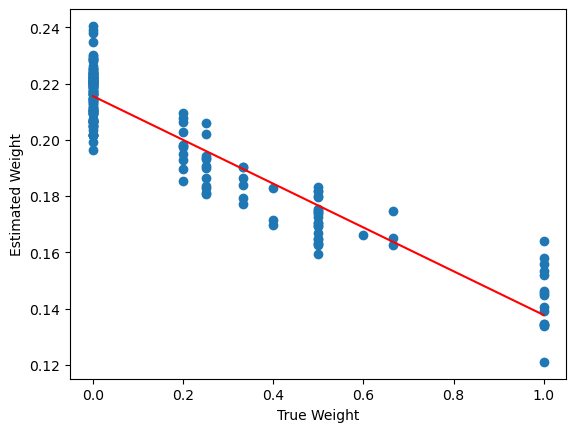

In [5]:
#Check performance
from scipy.stats import linregress

mean_post=post

plt.scatter(np.ravel(prop_vec), np.ravel(mean_post))
plt.xlabel("True Weight")
plt.ylabel("Estimated Weight")

line_fit=linregress(np.ravel(prop_vec), np.ravel(mean_post))

# Create sequence of 100 numbers from 0 to 100 
xseq = np.linspace(0, 1, num=100)

# Plot regression line
plt.plot(xseq, line_fit.intercept + line_fit.slope*xseq, 'r',)
plt.annotate("r-squared = {:.3f}".format(line_fit.rvalue**2), (0, 1))
plt.show()

In [14]:
np.real(d_spots)

(34, 2)

In [10]:
d_ref_exp

array([[-0.01339526+0.j, -0.01720142+0.j],
       [ 0.02173982+0.j, -0.00743548+0.j],
       [-0.00784333+0.j,  0.00805118+0.j],
       [ 0.00095933+0.j,  0.0040028 +0.j],
       [-0.00083991+0.j,  0.01490511+0.j]])

In [15]:
# Run alpha noise
import time

#Set default parameters
n_clusts = 5
n_genes = 500
n_cells = 100
rate_range = 0,40 #max and min of uniform distribution for generating rates
noise_type = 'exponential' #CHANGE!

start_time = time.time()
#Simulate spot data from simulated gene expression
spot_sim = cdfn.simulate_cell_mix(n_clusts, n_cells, n_genes).simulate_gene_exp(rate_range, 0)
n_spots = spot_sim.__dict__['n_spots']
spots = spot_sim.__dict__['spots']
ref_exp = spot_sim.__dict__['mean_exps']

eigval, eigvec = adfn.eigendecomposition(ref_exp)
k = 500#int(n_genes * p) #sum((eigval/np.sum(eigval)) > 0.005) 
ref_exp = np.real(adfn.pca(ref_exp, k))
prop_vec = spot_sim.__dict__['prop_vec']
spots = cdfn.add_noise(spots, per=None, a_std=5, g_std=5, e_std=5, noise_type=noise_type) #CHANGE!
spots = np.real(np.dot(spots, eigvec[:,:k]))

n_genes=k
#Simple Linear regression
with pm.Model(coords={"celltypes": np.arange(n_clusts),
                    "spots": np.arange(n_spots),
                    "genes": np.arange(n_genes) }) as model:
    #Declare data 
    mean_exp = pm.Data('mean_exp', ref_exp, mutable=False, dims=['celltypes','genes'])
    # Priors for unknown model parameters
    beta=pm.HalfNormal("beta", sigma=1, dims=['spots','celltypes'])
    lmd= pm.Deterministic('lmd', pm.math.dot(beta, mean_exp), dims=['spots','genes'])
    #Convert from proportions to counts
    N_g = pm.Data('N_g', np.sum(spots, 1).reshape(n_spots,1), mutable=False)
    #Likelihood of observed data given Poisson rates
    y=pm.Normal("y", mu=lmd*N_g, sigma=1, observed=spots)
with model: data=pm.sample(random_seed=1,draws=500,chains=1, discard_tuned_samples=False)
post, r2 = cdfn.model_stats(data, prop_vec, n_clusts)



Loaded parameters: 5 cell types , 100 cells, & 500 genes.
Created spot mixtures from simulated data: 34 spots.


AttributeError: module 'pymc' has no attribute 'Model'

In [13]:
r2

0.9528843881799802

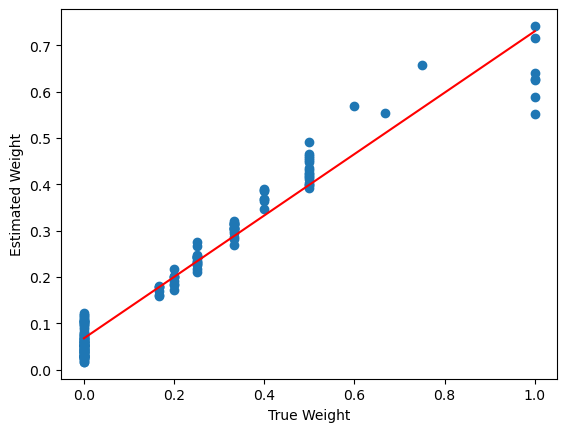

In [14]:
#Check performance
from scipy.stats import linregress

mean_post=post

plt.scatter(np.ravel(prop_vec), np.ravel(mean_post))
plt.xlabel("True Weight")
plt.ylabel("Estimated Weight")

line_fit=linregress(np.ravel(prop_vec), np.ravel(mean_post))

# Create sequence of 100 numbers from 0 to 100 
xseq = np.linspace(0, 1, num=100)

# Plot regression line
plt.plot(xseq, line_fit.intercept + line_fit.slope*xseq, 'r',)
plt.annotate("r-squared = {:.3f}".format(line_fit.rvalue**2), (0, 1))
plt.show()

In [ ]:
clust_list = np.linspace(3, 30, 7).astype(int)
genes_list = np.linspace(100, 3000, 7).astype(int)
cells_list = np.linspace(100, 3000, 7).astype(int)
list_list = [clust_list, genes_list, cells_list]
mode_list= ['nclusts', 'ngenes', 'nspots']

In [ ]:
# Run alpha noise
import time

model_type = 'lin-pca' #CHANGE!

for x,li in enumerate(list_list):
    mode = mode_list[x]

    for l in li:
        #Set default parameters
        n_clusts = 5
        n_genes = 800
        n_cells = 100
        if mode == 'nclusts':
            n_clusts = l
        if mode == 'ngenes':
            n_genes = l
        if mode == 'nspots':
            n_cells=l

        rate_range = 0,40 #max and min of uniform distribution for generating rates
        noise_type = 'exponential' #CHANGE!

        start_time = time.time()
        #Simulate spot data from simulated gene expression
        spot_sim = cdfn.simulate_cell_mix(n_clusts, n_cells, n_genes).simulate_gene_exp(rate_range, 0)
        n_spots = spot_sim.__dict__['n_spots']
        spots = spot_sim.__dict__['spots']
        ref_exp = spot_sim.__dict__['mean_exps']
        eigval, eigvec = adfn.eigendecomposition(ref_exp)
        k = sum((eigval/np.sum(eigval)) > 0.05) 
        ref_exp = adfn.pca(ref_exp, k)
        prop_vec = spot_sim.__dict__['prop_vec']
        spots = cdfn.add_noise(spots, per=None, a_std=5, g_std=5, e_std=5, noise_type=noise_type) #CHANGE!
        spots = np.dot(spots, eigvec[:,:k])

        model = cdfn.basic_pymc(n_clusts, n_spots, k, ref_exp, spots) #CHANGE!
        with model: data=pm.sample(random_seed=1,draws=200,chains=1, discard_tuned_samples=False)

        post, r2 = cdfn.model_stats(data, prop_vec, n_clusts)
        if len(str(l))<2:pref = '000' + str(l)
        elif len(str(l))<3:pref = '00' + str(l)
        elif len(str(l))<4:pref = '0' + str(l)
        else:pref= str(l)
        fin = (time.time() - start_time)

        np.save(s_data + 'spatial_transcriptomics/RCTD-test_noise-' + noise_type + '_model-' + model_type + '_' + mode + '-' + pref + '.npy', np.array([prop_vec, post, r2, fin], dtype=object))
        print(l)


In [ ]:
# Run alpha noise
import time

model_type = 'all-pca' #CHANGE!

for x,li in enumerate(list_list):
    mode = mode_list[x]

    for l in li:
        #Set default parameters
        n_clusts = 5
        n_genes = 800
        n_cells = 100
        if mode == 'nclusts':
            n_clusts = l
        if mode == 'ngenes':
            n_genes = l
        if mode == 'nspots':
            n_cells=l

        rate_range = 0,40 #max and min of uniform distribution for generating rates
        noise_type = 'exponential' #CHANGE!

        start_time = time.time()
        #Simulate spot data from simulated gene expression
        spot_sim = cdfn.simulate_cell_mix(n_clusts, n_cells, n_genes).simulate_gene_exp(rate_range, 0)
        n_spots = spot_sim.__dict__['n_spots']
        spots = spot_sim.__dict__['spots']
        ref_exp = spot_sim.__dict__['mean_exps']
        eigval, eigvec = adfn.eigendecomposition(ref_exp)
        k = sum((eigval/np.sum(eigval)) > 0.05) 
        ref_exp = adfn.pca(ref_exp, k)
        prop_vec = spot_sim.__dict__['prop_vec']
        spots = cdfn.add_noise(spots, per=None, a_std=5, g_std=5, e_std=5, noise_type=noise_type) #CHANGE!
        spots = np.dot(spots, eigvec[:,:k])

        model = cdfn.noise_pymc(n_clusts, n_spots, k, ref_exp, spots, noise_type=noise_type) #CHANGE!
        with model: data=pm.sample(random_seed=1,draws=200,chains=1, discard_tuned_samples=False)

        post, r2 = cdfn.model_stats(data, prop_vec, n_clusts)
        if len(str(l))<2:pref = '000' + str(l)
        elif len(str(l))<3:pref = '00' + str(l)
        elif len(str(l))<4:pref = '0' + str(l)
        else:pref= str(l)
        fin = (time.time() - start_time)

        np.save(s_data + 'spatial_transcriptomics/RCTD-test_noise-' + noise_type + '_model-' + model_type + '_' + mode + '-' + pref + '.npy', np.array([prop_vec, post, r2, fin], dtype=object))
        print(l)
